In [2]:
from flask import Flask, render_template
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64

In [3]:
app = Flask(__name__)

In [4]:
# bacalah file `googleplaystore.csv` data dan simpan ke objek dataframe dengan nama playstore
playstore = pd.read_csv("data/googleplaystore.csv")

In [5]:
playstore.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [6]:
# Hapus data yang duplikat berdasarkan kolom App, dengan tetap keep data pertama (hint : gunakan parameter subset)
playstore.drop_duplicates(subset= 'App', keep='first', inplace =True)

In [7]:
# bagian ini untuk menghapus row 10472 karena nilai data tersebut tidak tersimpan pada kolom yang benar
playstore.drop([10472], inplace=True)

In [8]:
# Cek tipe data kolom Category. Jika masih tersimpan dengan format tipe data yang salah, ubah ke tipe data yang sesuai
playstore.Category = playstore['Category'].astype('category')

In [9]:
# Pada kolom Installs Buang tanda koma(,) dan tanda tambah(+) kemudian ubah tipe data menjadi integer
playstore.Installs = playstore.Installs.apply(lambda x: x.replace("+",""))
playstore.Installs = playstore.Installs.apply(lambda x: x.replace(",",""))

In [10]:
# bagian untuk mengubah tipe data Installs
playstore.Installs = playstore.Installs.astype("int64")

In [11]:
# Bagian ini untuk merapikan kolom Size, Anda tidak perlu mengubah apapun di bagian ini
playstore['Size'].replace('Varies with device', np.nan, inplace = True ) 
playstore.Size = (playstore.Size.replace(r'[kM]+$', '', regex=True).astype(float) * \
             playstore.Size.str.extract(r'[\d\.]+([KM]+)', expand=False)
            .fillna(1)
            .replace(['k','M'], [10**3, 10**6]).astype(int))
playstore['Size'].fillna(playstore.groupby('Category')['Size'].transform('mean'),inplace = True)

In [12]:
# Pada kolom Price, buang karakater $ pada nilai Price lalu ubah tipe datanya menjadi float
playstore.Price = playstore.Price.apply(lambda x: x.replace("$",""))
playstore.Price = playstore.Price.astype("float64")

In [13]:
# Ubah tipe data Reviews, Size, Installs ke dalam tipe data integer
playstore[["Reviews","Size","Installs"]] = playstore[["Reviews","Size","Installs"]].astype("int64")

In [14]:
@app.route("/")
# This fuction for rendering the table
def index():
    df2 = playstore.copy()

In [16]:
  # Statistik
    # Dataframe top_category dibuat untuk menyimpan frekuensi aplikasi untuk setiap Category. 
    # Gunakan crosstab untuk menghitung frekuensi aplikasi di setiap category kemudian gunakan 'Jumlah'
    # sebagai nama kolom dan urutkan nilai frekuensi dari nilai yang paling banyak. Terakhir reset index dari dataframe top_category 
top_category = pd.crosstab(index=df2['Category'], columns='jumlah').sort_values("jumlah", ascending=False).reset_index()

NameError: name 'df2' is not defined

In [88]:
top_category.head()

col_0,Category,jumlah
0,FAMILY,1832
1,GAME,959
2,TOOLS,827
3,BUSINESS,420
4,MEDICAL,395


In [72]:
    # Dictionary stats digunakan untuk menyimpan beberapa data yang digunakan untuk menampilkan nilai di value box dan tabel
stats = {
        # Ini adalah bagian untuk melengkapi konten value box 
        # most category mengambil nama category paling banyak mengacu pada dataframe top_category
        # total mengambil frekuensi/jumlah category paling banyak mengacu pada dataframe top_category
        'most_categories' : top_category['Category'][0],
        'total': top_category['jumlah'][0],
        # rev_table adalah tabel yang berisi 10 aplikasi yang paling banyak direview oleh pengguna. 
        # Silahkan melakukan agregasi data yang tepat menggunakan groupby untuk menampilkan 10 aplikasi yang diurutkan berdasarkan 
        # jumlah Review pengguna. Tabel yang ditampilkan terdiri dari 4 kolom yaitu nama Category, nama App, total Reviews, dan rata-rata Rating.
        # Agregasi Anda dinilai benar jika hasilnya sama dengan tabel yang terlampir pada file ini
        'rev_table' : df2[["Category","App","Reviews","Rating"]].groupby(["Category","App"]).\
        agg({"Reviews": "sum",
             "Rating": "mean"}).\
        sort_values(['Reviews','Category'], ascending=False).\
        groupby(['Category','Reviews']).\
        head(5).reset_index().head(10).to_html(classes=['table thead-light table-striped table-bordered table-hover table-sm'])
}

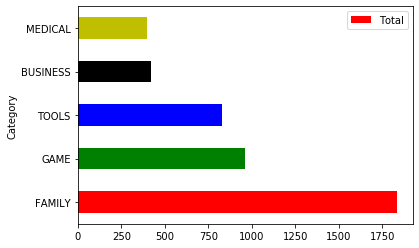

In [73]:
## Bar Plot
    ## Lengkapi tahap agregasi untuk membuat dataframe yang mengelompokkan aplikasi berdasarkan Category
    ## Buatlah bar plot dimana axis x adalah nama Category dan axis y adalah jumlah aplikasi pada setiap kategori, kemudian urutkan dari jumlah terbanyak
X = 'Category'
Y = 'App'
my_colors = 'rgbkymc'

cat_order = df2.groupby('Category').agg({
    'App' : 'count'
}).rename({'App':'Total'}, axis=1).sort_values(by='Total',ascending=False).head().plot.barh(color=my_colors)

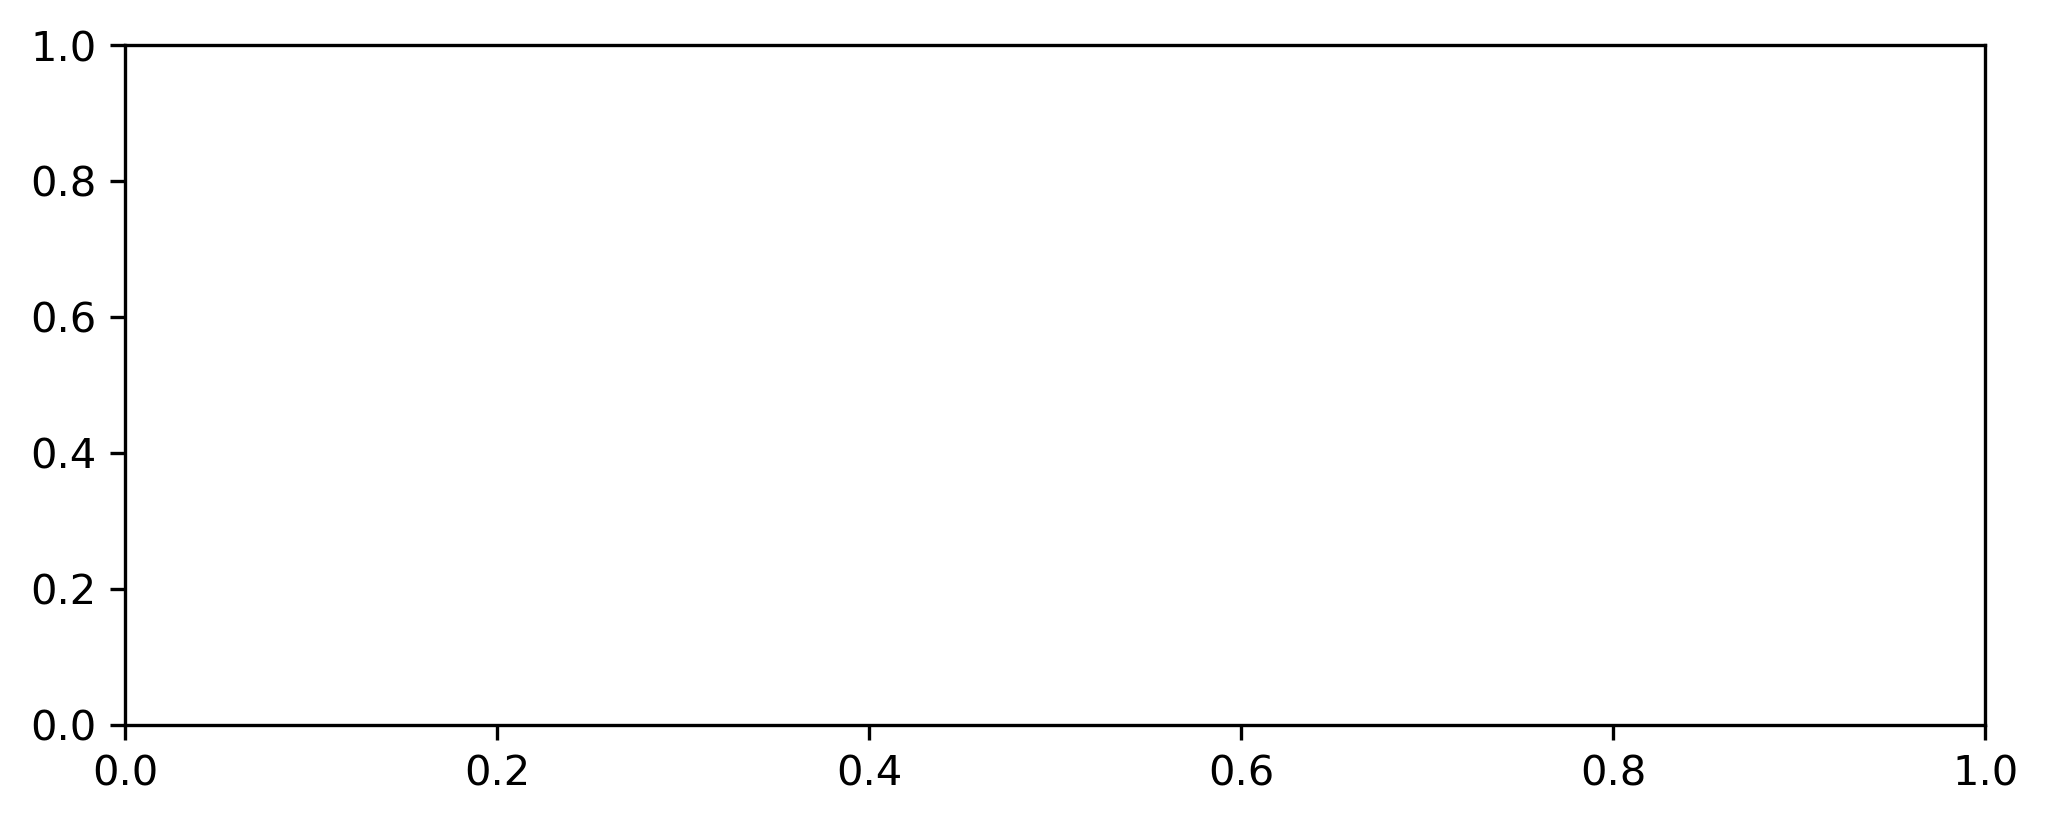

In [74]:
 # bagian ini digunakan untuk membuat kanvas/figure
fig = plt.figure(figsize=(8,3),dpi=300)
fig.add_subplot()

<BarContainer object of 1 artists>

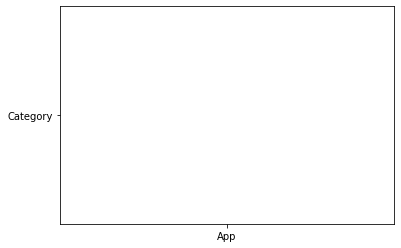

In [75]:
plt.barh(X,Y, color=my_colors)

In [76]:
# bagian ini digunakan untuk menyimpan plot dalam format image.png
plt.savefig('cat_order.png',bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

In [77]:
df2.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


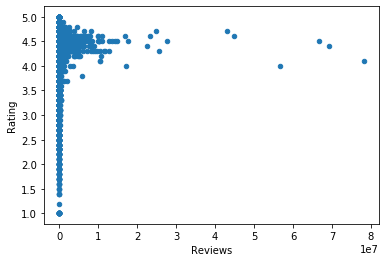

In [78]:
df2.plot.scatter(x='Reviews',
                y='Rating')

In [79]:
# bagian ini digunakan untuk mengconvert matplotlib png ke base64 agar dapat ditampilkan ke template html
figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())

<Figure size 432x288 with 0 Axes>

In [80]:
# variabel result akan dimasukkan ke dalam parameter di fungsi render_template() agar dapat ditampilkan di 
# halaman html
result = str(figdata_png)[2:-1]

In [1]:
# Buatlah scatter plot untuk menampilkan hubungan dan persebaran apalikasi dilihat dari Review vs Rating.
# Ukuran scatter menggambarkan berapa banyak pengguna yang telah menginstall aplikasi 
X = df2['Reviews'].values # axis x
Y = df2['Rating'].values # axis y
area = playstore['Installs'].values/10000000 # ukuran besar/kecilnya lingkaran scatter plot
fig = plt.figure(figsize=(5,5))
fig.add_subplot()

# isi nama method untuk scatter plot, variabel x, dan variabel y
plt.scatter(x='count',y='count', s=area, alpha=0.3)
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.savefig('rev_rat.png',bbox_inches="tight")

figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())
result2 = str(figdata_png)[2:-1]

NameError: name 'df2' is not defined

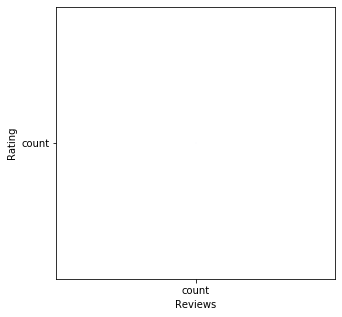

In [82]:
 ## Scatter Plot
# Buatlah scatter plot untuk menampilkan hubungan dan persebaran apalikasi dilihat dari Review vs Rating.
# Ukuran scatter menggambarkan berapa banyak pengguna yang telah menginstall aplikasi 
X = df2['Reviews'].values # axis x
Y = df2["Rating"].values # axis y
area = playstore["Installs"].values/10000000 # ukuran besar/kecilnya lingkaran scatter plot
fig = plt.figure(figsize=(5,5))
fig.add_subplot()

# isi nama method untuk scatter plot, variabel x, dan variabel y
plt.scatter(x='count',y='count', s=area, alpha=0.3)
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.savefig('rev_rat.png',bbox_inches="tight")

In [83]:
figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())
result2 = str(figdata_png)[2:-1]

<Figure size 432x288 with 0 Axes>

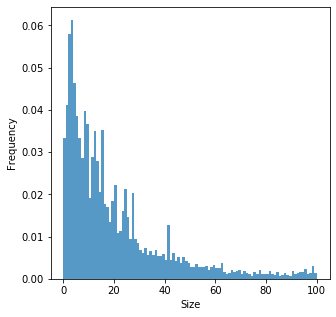

In [84]:
## Histogram Size Distribution
# Buatlah sebuah histogram yang menggambarkan distribusi Size aplikasi dalam satuan Mb(Megabytes) 
# Histogram yang terbentuk terbagi menjadi 100 bins
X=(df2['Size']/1000000).values
fig = plt.figure(figsize=(5,5))
fig.add_subplot()
plt.hist(X,bins=100, density=True,  alpha=0.75)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.savefig('hist_size.png',bbox_inches="tight")

figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())
result3 = str(figdata_png)[2:-1]

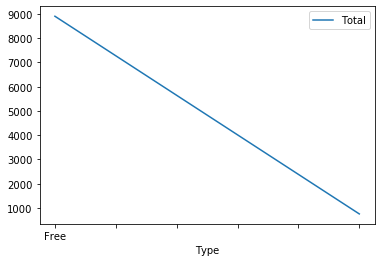

In [85]:
    ## Buatlah sebuah plot yang menampilkan insight di dalam data 
Type_order = df2.groupby('Type').agg({
    'Type' : 'count'
}).rename({'Type':'Total'}, axis=1).sort_values(by='Total',ascending=False).head().plot.line()

figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())
result4 = str(figdata_png)[2:-1]
